#Feature Extraction

The aim of this jupyter notebook is to build upon the data file extraction made by Amanda. The main idea is to use pre
existing libraries susch as *scikit-learn*. The main goal is to learn the basics, and train a machine learning model
quickly and easily.

In [167]:
# First we will extract the data, and save it to a csv.

import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb


In [168]:
train_a = pd.read_parquet('A/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')

## Preprocessing of data
In this step we prep the data for the machine learning algorithm.

In [169]:
def data_length_matching(train: pd.DataFrame, obs: pd.DataFrame)-> tuple[pd.DataFrame, pd.DataFrame]:
    """
    This function is intended to ensure that both the training data and
    the observed data are sorted, and contain the same number of entries. 
    """

    # Cut the data frames so that their date match.
    obs_feature_test = obs[obs['date_forecast'].isin(train['time'])].sort_values(by=['date_forecast'])  # sortert etter datao
    # If only one of them has the date ensure that the other also has the same sorting.
    train_feature_test = train[train['time'].isin(obs['date_forecast'])].sort_values(by=['time'])       # sortert etter datao

    return train_feature_test, obs_feature_test

X_total = pd.concat([X_train_estimated_a, X_train_observed_a], axis = 0)

y, X = data_length_matching(train_a, X_total)



X = X.drop('date_forecast', axis=1)
X = X.drop('date_calc', axis=1)
X = X.interpolate(method='linear')
X = X.fillna(method="backfill", axis=None)
y = y.drop('time', axis=1)

X_best = SelectKBest(f_regression, k=6).fit_transform(X.values, y.values)

# DO we get a day or the 
xtrain, xtest, ytrain, ytest=train_test_split(X_best, y, test_size=0.15)

scaler = MinMaxScaler()

# Fit and transform the data
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)



C:\Users\asber\AppData\Local\Temp\ipykernel_16244\2667332131.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="backfill", axis=None)
c:\Users\asber\anaconda3\envs\basic_machine_learning\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## AI Training: GradientBoostingRegressor

c:\Users\asber\anaconda3\envs\basic_machine_learning\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


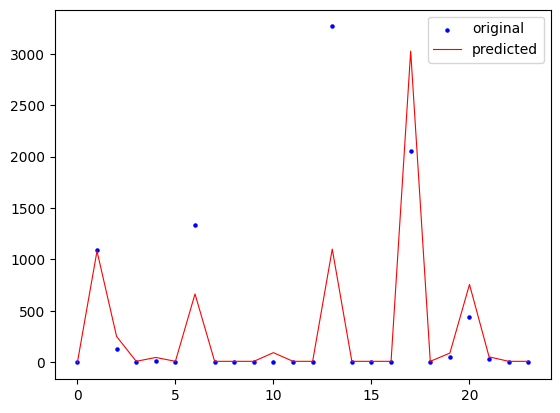

The mean square error is 221549.71305054243


In [170]:

gbr = GradientBoostingRegressor(n_estimators=600, 
    max_depth=5, 
    learning_rate=0.01, 
    min_samples_split=3)


#+====================================================================================================================+
#| Additional idea: Notice that time of day parameters will probably be provided... Fitting this to a location might  |
#| give us an edge needed to fit a better algorithm for each location...                                              |
#+====================================================================================================================+

gbr.fit(xtrain, ytrain)
ypred = gbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)


X_test_estimated_a


x_ax = range(24)
plt.scatter(x_ax, ytest[24:48], s=5, color="blue", label="original")
plt.plot(x_ax, ypred[24:48], lw=0.8, color="red", label="predicted")

plt.legend()
plt.show()

print("The mean square error is", mse)
#240441.0648973231


In [171]:


# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the XGBoost model
xgb_model = xgb.XGBRegressor()

# Define a parameter grid to search through
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(xtrain, ytrain)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(xtrain, ytrain)

# Make predictions on the test set
ypred = best_model.predict(xtest)

# Evaluate the model
mse = mean_squared_error(ytest, ypred)
print("Mean Squared Error:", mse)


print(np.mean(y_pred - y))

c:\Users\asber\anaconda3\envs\basic_machine_learning\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\asber\anaconda3\envs\basic_machine_learning\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\Users\asber\anaconda3\envs\basic_machine_learning\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\asber\anaconda3\envs\basic_machine_learning\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fu

Mean Squared Error: 222034.1999378944


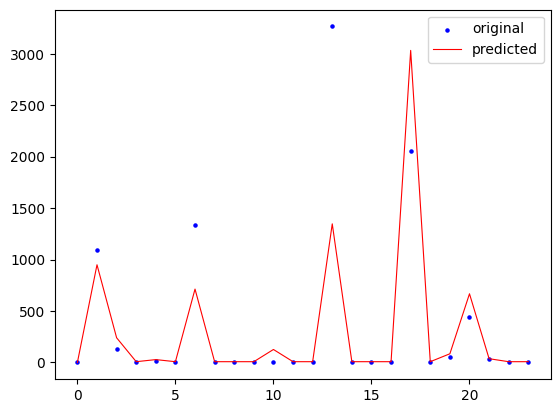

0.4002230459368921


In [182]:
x_ax = range(24)
plt.scatter(x_ax, ytest[24:48], s=5, color="blue", label="original")
plt.plot(x_ax, ypred[24:48], lw=0.8, color="red", label="predicted")

plt.legend()
plt.show()
x = (np.array(ypred)-np.array(ytest))

print(np.mean(x)**2)